In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from sklearn.tree import DecisionTreeClassifier

In [2]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [3]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [4]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [5]:
df.shape

(292, 15)

In [6]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [7]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [8]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [9]:
X.shape

(292, 7)

In [10]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
model_choice = DecisionTreeClassifier()

In [13]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [14]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [15]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [16]:
y_pred_proba = clf.predict_proba(X_test)

In [17]:
np.round(accuracy_score(y_test, y_pred), 2)

0.87

In [18]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [19]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [20]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.783, 0.108)

In [21]:
tn, fp, fn, tp

(66, 8, 5, 18)

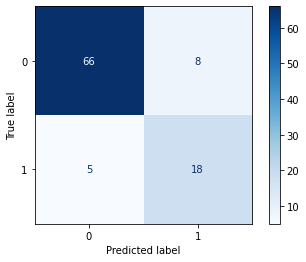

In [22]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [24]:
auc_score = auc(fpr, tpr)

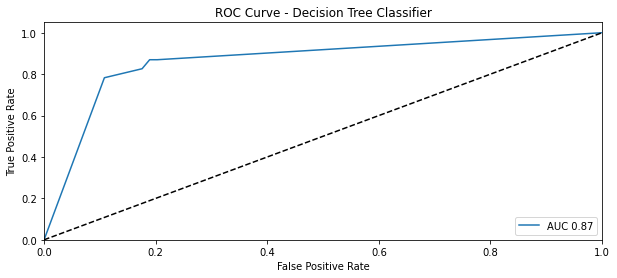

In [25]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [26]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 2.0
TPR 0.782608695652174, FPR 0.10810810810810811, Threshold 1.0
TPR 0.8260869565217391, FPR 0.17567567567567569, Threshold 0.5
TPR 0.8695652173913043, FPR 0.1891891891891892, Threshold 0.42857142857142855
TPR 0.8695652173913043, FPR 0.20270270270270271, Threshold 0.3333333333333333
TPR 1.0, FPR 1.0, Threshold 0.0


## Bootstrapped

In [27]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9025, Accuracy:0.8969072164948454
Iteration 1: AUC:0.8009634888438134, Accuracy:0.7835051546391752
Iteration 2: AUC:0.8287309048178614, Accuracy:0.8350515463917526
Iteration 3: AUC:0.8741438356164384, Accuracy:0.8762886597938144
Iteration 4: AUC:0.7692307692307692, Accuracy:0.8144329896907216
Iteration 5: AUC:0.846031746031746, Accuracy:0.8144329896907216
Iteration 6: AUC:0.8805288461538461, Accuracy:0.845360824742268
Iteration 7: AUC:0.8455555555555555, Accuracy:0.8247422680412371
Iteration 8: AUC:0.7542808219178082, Accuracy:0.7835051546391752
Iteration 9: AUC:0.8683901292596945, Accuracy:0.8762886597938144
Iteration 10: AUC:0.9050207039337475, Accuracy:0.865979381443299
Iteration 11: AUC:0.8113590263691683, Accuracy:0.8041237113402062
Iteration 12: AUC:0.8608465608465609, Accuracy:0.8865979381443299
Iteration 13: AUC:0.8415343915343916, Accuracy:0.8144329896907216
Iteration 14: AUC:0.8230593607305936, Accuracy:0.7938144329896907
Iteration 15: AUC:0.741874322860238

Iteration 148: AUC:0.8477746212121212, Accuracy:0.8556701030927835
Iteration 149: AUC:0.7538032454361056, Accuracy:0.8041237113402062
Iteration 150: AUC:0.791497975708502, Accuracy:0.8350515463917526
Iteration 151: AUC:0.8228365384615384, Accuracy:0.8144329896907216
Iteration 152: AUC:0.8507638072855463, Accuracy:0.8556701030927835
Iteration 153: AUC:0.8164954337899544, Accuracy:0.8144329896907216
Iteration 154: AUC:0.7788359788359788, Accuracy:0.8247422680412371
Iteration 155: AUC:0.8103002070393375, Accuracy:0.8247422680412371
Iteration 156: AUC:0.8415343915343915, Accuracy:0.8762886597938144
Iteration 157: AUC:0.828819068255688, Accuracy:0.845360824742268
Iteration 158: AUC:0.7828674948240166, Accuracy:0.8041237113402062
Iteration 159: AUC:0.8544624746450304, Accuracy:0.8762886597938144
Iteration 160: AUC:0.7763888888888889, Accuracy:0.8350515463917526
Iteration 161: AUC:0.8365079365079366, Accuracy:0.8144329896907216
Iteration 162: AUC:0.8795534665099882, Accuracy:0.876288659793814

Iteration 290: AUC:0.8678787878787878, Accuracy:0.8350515463917526
Iteration 291: AUC:0.8575757575757577, Accuracy:0.8556701030927835
Iteration 292: AUC:0.8874824191279888, Accuracy:0.865979381443299
Iteration 293: AUC:0.839041095890411, Accuracy:0.8350515463917526
Iteration 294: AUC:0.9245005875440657, Accuracy:0.8865979381443299
Iteration 295: AUC:0.8982587064676617, Accuracy:0.8556701030927835
Iteration 296: AUC:0.8466955579631635, Accuracy:0.8762886597938144
Iteration 297: AUC:0.8069444444444444, Accuracy:0.865979381443299
Iteration 298: AUC:0.7343283582089551, Accuracy:0.8041237113402062
Iteration 299: AUC:0.8684848484848486, Accuracy:0.8556701030927835
Iteration 300: AUC:0.7927018633540373, Accuracy:0.7835051546391752
Iteration 301: AUC:0.7977272727272728, Accuracy:0.8041237113402062
Iteration 302: AUC:0.83261105092091, Accuracy:0.8969072164948454
Iteration 303: AUC:0.8422077922077922, Accuracy:0.8144329896907216
Iteration 304: AUC:0.8256493506493505, Accuracy:0.865979381443299
I

Iteration 414: AUC:0.8152173913043479, Accuracy:0.8556701030927835
Iteration 415: AUC:0.8146766169154229, Accuracy:0.845360824742268
Iteration 416: AUC:0.9101027397260275, Accuracy:0.865979381443299
Iteration 417: AUC:0.8230593607305936, Accuracy:0.845360824742268
Iteration 418: AUC:0.9040084388185654, Accuracy:0.8762886597938144
Iteration 419: AUC:0.7508813160987075, Accuracy:0.8041237113402062
Iteration 420: AUC:0.8061111111111112, Accuracy:0.865979381443299
Iteration 421: AUC:0.8185265438786565, Accuracy:0.865979381443299
Iteration 422: AUC:0.8315276273022751, Accuracy:0.8247422680412371
Iteration 423: AUC:0.8713888888888888, Accuracy:0.865979381443299
Iteration 424: AUC:0.7596348884381339, Accuracy:0.8247422680412371
Iteration 425: AUC:0.8619402985074627, Accuracy:0.8247422680412371
Iteration 426: AUC:0.834920634920635, Accuracy:0.845360824742268
Iteration 427: AUC:0.7505875440658049, Accuracy:0.7731958762886598
Iteration 428: AUC:0.7619047619047619, Accuracy:0.7731958762886598
Ite

Iteration 538: AUC:0.7833850931677019, Accuracy:0.7835051546391752
Iteration 539: AUC:0.8171722643553628, Accuracy:0.8350515463917526
Iteration 540: AUC:0.8290899241603467, Accuracy:0.8041237113402062
Iteration 541: AUC:0.7724025974025974, Accuracy:0.8041237113402062
Iteration 542: AUC:0.7828674948240165, Accuracy:0.8041237113402062
Iteration 543: AUC:0.722636815920398, Accuracy:0.7835051546391752
Iteration 544: AUC:0.7807971014492754, Accuracy:0.8144329896907216
Iteration 545: AUC:0.876984126984127, Accuracy:0.8556701030927835
Iteration 546: AUC:0.7826923076923077, Accuracy:0.8041237113402062
Iteration 547: AUC:0.7938596491228069, Accuracy:0.845360824742268
Iteration 548: AUC:0.8535714285714286, Accuracy:0.8556701030927835
Iteration 549: AUC:0.8506493506493507, Accuracy:0.8350515463917526
Iteration 550: AUC:0.7884848484848485, Accuracy:0.8247422680412371
Iteration 551: AUC:0.8783333333333333, Accuracy:0.865979381443299
Iteration 552: AUC:0.8514925373134329, Accuracy:0.845360824742268


Iteration 662: AUC:0.7951318458417849, Accuracy:0.7938144329896907
Iteration 663: AUC:0.7912698412698412, Accuracy:0.8144329896907216
Iteration 664: AUC:0.8714285714285714, Accuracy:0.8556701030927835
Iteration 665: AUC:0.7791044776119403, Accuracy:0.8144329896907216
Iteration 666: AUC:0.8165865384615385, Accuracy:0.7938144329896907
Iteration 667: AUC:0.7587991718426502, Accuracy:0.8144329896907216
Iteration 668: AUC:0.8227513227513228, Accuracy:0.8041237113402062
Iteration 669: AUC:0.781107305936073, Accuracy:0.7731958762886598
Iteration 670: AUC:0.8670091324200914, Accuracy:0.8350515463917526
Iteration 671: AUC:0.8047945205479452, Accuracy:0.8247422680412371
Iteration 672: AUC:0.7872727272727271, Accuracy:0.8350515463917526
Iteration 673: AUC:0.8266045548654244, Accuracy:0.845360824742268
Iteration 674: AUC:0.7951127819548872, Accuracy:0.7938144329896907
Iteration 675: AUC:0.8658730158730159, Accuracy:0.8556701030927835
Iteration 676: AUC:0.8281818181818182, Accuracy:0.82474226804123

Iteration 790: AUC:0.7825027085590466, Accuracy:0.8041237113402062
Iteration 791: AUC:0.8584134615384615, Accuracy:0.8247422680412371
Iteration 792: AUC:0.802121212121212, Accuracy:0.8556701030927835
Iteration 793: AUC:0.7627777777777778, Accuracy:0.7938144329896907
Iteration 794: AUC:0.8586956521739131, Accuracy:0.8350515463917526
Iteration 795: AUC:0.7911111111111111, Accuracy:0.7938144329896907
Iteration 796: AUC:0.8381818181818183, Accuracy:0.7835051546391752
Iteration 797: AUC:0.8096969696969697, Accuracy:0.7835051546391752
Iteration 798: AUC:0.847237269772481, Accuracy:0.8556701030927835
Iteration 799: AUC:0.8, Accuracy:0.8041237113402062
Iteration 800: AUC:0.8877777777777778, Accuracy:0.8762886597938144
Iteration 801: AUC:0.8512121212121212, Accuracy:0.8762886597938144
Iteration 802: AUC:0.8291666666666666, Accuracy:0.845360824742268
Iteration 803: AUC:0.8150054171180932, Accuracy:0.8556701030927835
Iteration 804: AUC:0.8171722643553629, Accuracy:0.845360824742268
Iteration 805:

Iteration 916: AUC:0.774966261808367, Accuracy:0.8247422680412371
Iteration 917: AUC:0.853968253968254, Accuracy:0.8247422680412371
Iteration 918: AUC:0.8418201516793066, Accuracy:0.7938144329896907
Iteration 919: AUC:0.8477777777777777, Accuracy:0.8350515463917526
Iteration 920: AUC:0.7588742393509127, Accuracy:0.8041237113402062
Iteration 921: AUC:0.8418866080156403, Accuracy:0.845360824742268
Iteration 922: AUC:0.8921212121212122, Accuracy:0.8865979381443299
Iteration 923: AUC:0.8197261663286004, Accuracy:0.8041237113402062
Iteration 924: AUC:0.8233137829912023, Accuracy:0.8247422680412371
Iteration 925: AUC:0.8805970149253731, Accuracy:0.8556701030927835
Iteration 926: AUC:0.8907867494824016, Accuracy:0.8556701030927835
Iteration 927: AUC:0.8313356164383561, Accuracy:0.8144329896907216
Iteration 928: AUC:0.8491379310344828, Accuracy:0.8247422680412371
Iteration 929: AUC:0.8875576036866359, Accuracy:0.8969072164948454
Iteration 930: AUC:0.8072139303482587, Accuracy:0.804123711340206

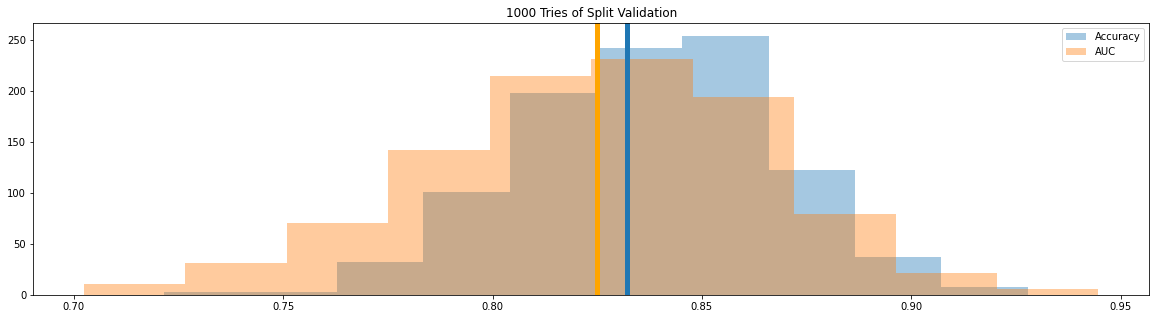

Accuracy mean: 0.83
AUC mean: 0.82


In [28]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [29]:
## Hyperparameters
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
min_samples_split = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = DecisionTreeClassifier(random_state=0)

In [31]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [32]:
cv_results

array([0.81168831, 0.73863636, 0.85876623, 0.82954545, 0.9637931 ])

In [33]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [34]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [35]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [36]:
clf = model_choice.fit(X_train_best, y_train_best)
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9637931034482758

In [37]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best)
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.850470035252644

#### Calculate Results

In [111]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
depths = []
samples_split = []
idx_train_data = []

## Hyperparameters
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
min_samples_split = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(max_depth)):
    for j in range(len(min_samples_split)):
        
        ## Fit the params
        model_choice = DecisionTreeClassifier\
        (random_state=0, max_depth=max_depth[i], min_samples_split=min_samples_split[j])

        ## Do cross validation
        cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

        ## Get the index best fold train data to be tested on dataset B
        idx = 0
        idx_train_best = []
        idx_test_best = []
        for train, test in kfold.split(X_train, y_train):
            if idx == np.argmax(cv_results):
                idx_train_best = train
                idx_test_best = test
            idx += 1

        ## Get the best fold train and test data
        X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
        y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

        X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
        y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

        ## Fit the model with the best fold data
        clf = model_choice.fit(X_train_best, y_train_best)

        ## Test the best fold to dataset B
        ## Check the AUC on dataset B
        y_test_proba = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
        auc_score = auc(fpr, tpr)
        
        best_fold.append(np.argmax(cv_results)+1)
        best_fold_auc.append(np.max(cv_results))
        dataset_b_auc.append(auc_score)
        depths.append(max_depth[i])
        samples_split.append(min_samples_split[j])
        idx_train_data.append(idx_train_best)
        
        print("Max Depth: %s, Min. Sample Split: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
              % (max_depth[i], min_samples_split[j], np.max(cv_results), np.argmax(cv_results)+1, auc_score))

Max Depth: 1, Min. Sample Split: 5, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 10, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 15, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 20, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 25, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 30, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 35, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 40, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B AUC: 0.8063492063492064
Max Depth: 1, Min. Sample Split: 45, Best Fold AUC: 0.926470588235294 (Fold 5), Dataset B

Max Depth: 5, Min. Sample Split: 65, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 5, Min. Sample Split: 70, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 5, Min. Sample Split: 75, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 6, Min. Sample Split: 5, Best Fold AUC: 0.8897058823529412 (Fold 5), Dataset B AUC: 0.9055555555555554
Max Depth: 6, Min. Sample Split: 10, Best Fold AUC: 0.9411764705882353 (Fold 5), Dataset B AUC: 0.9325396825396826
Max Depth: 6, Min. Sample Split: 15, Best Fold AUC: 0.9754901960784313 (Fold 5), Dataset B AUC: 0.9507936507936509
Max Depth: 6, Min. Sample Split: 20, Best Fold AUC: 0.9754901960784313 (Fold 5), Dataset B AUC: 0.953968253968254
Max Depth: 6, Min. Sample Split: 25, Best Fold AUC: 0.9901960784313726 (Fold 5), Dataset B AUC: 0.9571428571428571
Max Depth: 6, Min. Sample Split: 30, Best Fold AUC: 0.9656862745098038 (Fold 4), D

Max Depth: 10, Min. Sample Split: 50, Best Fold AUC: 0.9558823529411765 (Fold 4), Dataset B AUC: 0.9047619047619048
Max Depth: 10, Min. Sample Split: 55, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 10, Min. Sample Split: 60, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 10, Min. Sample Split: 65, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 10, Min. Sample Split: 70, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 10, Min. Sample Split: 75, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 11, Min. Sample Split: 5, Best Fold AUC: 0.8909313725490194 (Fold 5), Dataset B AUC: 0.8976190476190475
Max Depth: 11, Min. Sample Split: 10, Best Fold AUC: 0.9411764705882353 (Fold 5), Dataset B AUC: 0.9325396825396826
Max Depth: 11, Min. Sample Split: 15, Best Fold AUC: 0.9754901960784313 (

Max Depth: 15, Min. Sample Split: 35, Best Fold AUC: 0.9644607843137254 (Fold 5), Dataset B AUC: 0.9634920634920634
Max Depth: 15, Min. Sample Split: 40, Best Fold AUC: 0.9558823529411765 (Fold 4), Dataset B AUC: 0.9134920634920636
Max Depth: 15, Min. Sample Split: 45, Best Fold AUC: 0.9558823529411765 (Fold 4), Dataset B AUC: 0.9047619047619048
Max Depth: 15, Min. Sample Split: 50, Best Fold AUC: 0.9558823529411765 (Fold 4), Dataset B AUC: 0.9047619047619048
Max Depth: 15, Min. Sample Split: 55, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 15, Min. Sample Split: 60, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 15, Min. Sample Split: 65, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 15, Min. Sample Split: 70, Best Fold AUC: 0.9362745098039216 (Fold 4), Dataset B AUC: 0.9238095238095237
Max Depth: 15, Min. Sample Split: 75, Best Fold AUC: 0.9362745098039216 

In [112]:
df_result = pd.DataFrame({"max_depth": depths, "min_samples_split": samples_split, "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc,train_idx
0,1,5,5,0.926471,0.806349,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,10,5,0.926471,0.806349,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1,15,5,0.926471,0.806349,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1,20,5,0.926471,0.806349,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,1,25,5,0.926471,0.806349,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [113]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc
0,1,5,5,0.926471,0.806349
1,1,10,5,0.926471,0.806349
2,1,15,5,0.926471,0.806349
3,1,20,5,0.926471,0.806349
4,1,25,5,0.926471,0.806349


In [114]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,max_depth,min_samples_split,fold_index,best_fold_auc,test_auc
51,4,35,5,0.964461,0.963492
66,5,35,5,0.964461,0.963492
81,6,35,5,0.964461,0.963492
96,7,35,5,0.964461,0.963492
111,8,35,5,0.964461,0.963492


In [115]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_max_depth = df_result[df_result.test_auc == df_result.test_auc.max()]['max_depth'].iloc[0]
best_min_samples_split = df_result[df_result.test_auc == df_result.test_auc.max()]['min_samples_split'].iloc[0]

In [116]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [117]:
clf = DecisionTreeClassifier\
        (random_state=0, max_depth=best_max_depth, min_samples_split=best_min_samples_split)

In [118]:
clf.fit(X_train_chosen, y_train_chosen)
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [119]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.963
Accuracy: 0.932 
Precision: 0.917 
Recall: 0.786 
F1 Score: 0.846 


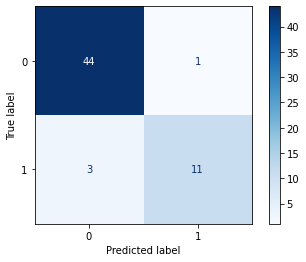

In [120]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [121]:
print("True Positive: %s" % tp)
print("False Pasitive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 11
False Pasitive: 1
True Negative: 44
False Negative: 3


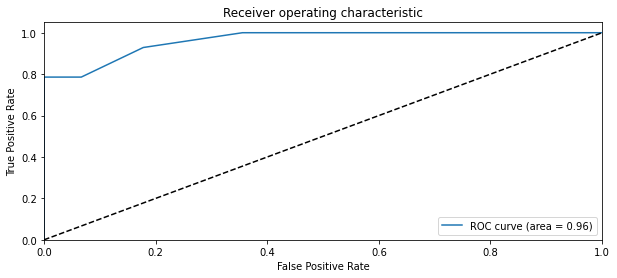

In [122]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Dump To Pickle

In [42]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [43]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()